# Importing Libraries

In [1]:
#Data Importing
import opendatasets as od
import os
import datetime

# Data wrangling
import pandas as pd
import numpy as np

# Data visualisation
import seaborn as sns
sns.set_style('darkgrid')   # blackgrid
import matplotlib as plt
import matplotlib.pyplot as plt
from pylab import rcParams

#Statistics
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from dateutil.parser import parse
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import acf

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Importing and Reading Data

In [2]:
dataset_url='https://www.kaggle.com/datasets/arashnic/learn-time-series-forecasting-from-gold-price?datasetId=984101&sortBy=voteCount'

In [3]:
od.download(dataset_url)

Skipping, found downloaded files in ".\learn-time-series-forecasting-from-gold-price" (use force=True to force download)


In [4]:
data_dir = './learn-time-series-forecasting-from-gold-price'

In [5]:
os.listdir(data_dir)

['gold_price_data.csv']

In [6]:
df = pd.read_csv('./learn-time-series-forecasting-from-gold-price/gold_price_data.csv')

In [7]:
df.head()

,Date,Value
0,1970-01-01,35.2
1,1970-04-01,35.1
2,1970-07-01,35.4
3,1970-10-01,36.2
4,1971-01-01,37.4


# Understanding the Data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10787 entries, 0 to 10786
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    10787 non-null  object 
 1   Value   10787 non-null  float64
dtypes: float64(1), object(1)
memory usage: 168.7+ KB


Insights:
- As we can the Date in df is of the type object. It shall be prudent for us to convert it into the Date-time type and also to make the Date column as our Index.
- There is no null values either in the data

In [9]:
# changing the datatype for the date column

df['Date'] = pd.to_datetime(df['Date'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10787 entries, 0 to 10786
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    10787 non-null  datetime64[ns]
 1   Value   10787 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 168.7 KB


In [11]:
df.head()

,Date,Value
0,1970-01-01,35.2
1,1970-04-01,35.1
2,1970-07-01,35.4
3,1970-10-01,36.2
4,1971-01-01,37.4


In [12]:
# setting the date column as index

df = df.set_index('Date', drop = True)
df.head()

,Value
Date,
1970-01-01,35.2
1970-04-01,35.1
1970-07-01,35.4
1970-10-01,36.2
1971-01-01,37.4


In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Value,10787.0,653.596634,434.030848,35.1,349.2,409.35,1061.625,1895.0


# Visualizations

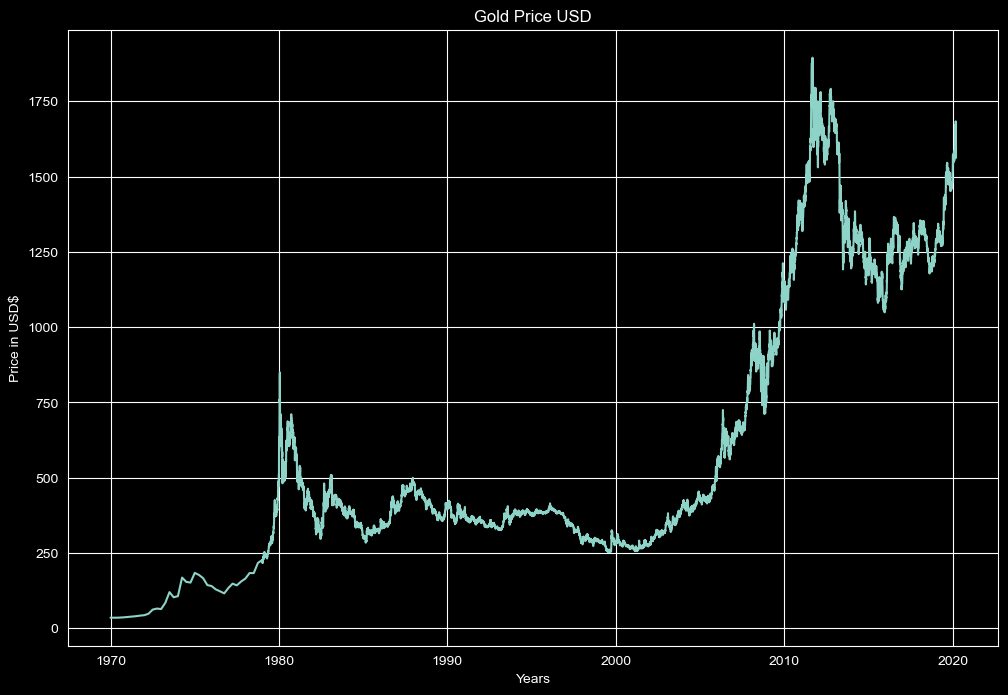

In [14]:
import matplotlib.pyplot as plt
# Use dark background style
plt.style.use('dark_background')
# sns.set_style('darkgrid')

plt.figure(figsize = (12, 8))
plt.plot(df)
plt.xlabel("Years")
plt.ylabel("Price in USD$")
plt.title("Gold Price USD")
plt.show()

Insights :
    
- Since this data consists of trend as well as seasonality, that means there can be a case of unstationarity

<Axes: xlabel='Date'>

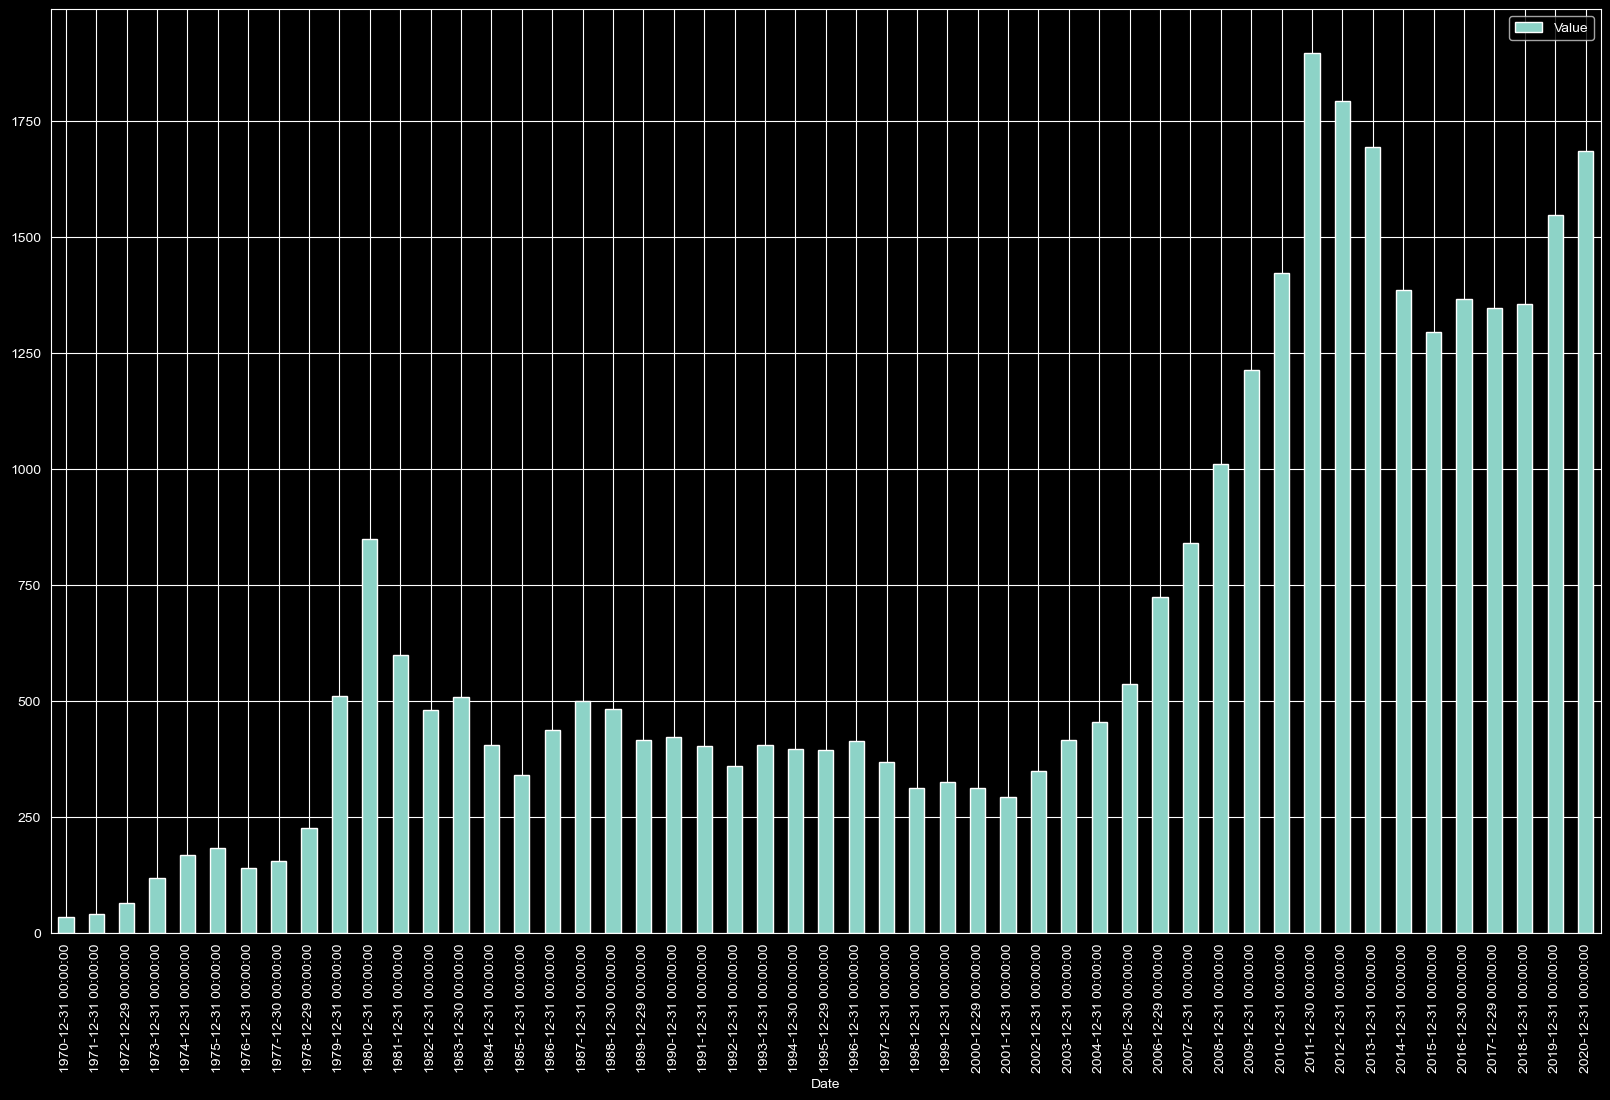

In [15]:
# Highest Price each year in Bar Graph

df.resample(rule='BA').max().plot(figsize=(20,12),kind='bar')

Insights :
- Since the year 2001, it can be seen that the trend has been going upwards
- And the highest price of gold was on the year of 2011

# Decomposition of Time Series

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose(df, col_name):
    res_add = seasonal_decompose(df['Value'], model = 'additive', extrapolate_trend = 'freq', period = 365)
    res_mul = seasonal_decompose(df['Value'], model = 'multiplicative', extrapolate_trend = 'freq', period = 365)
    
    plt.rcParams.update({'figure.figsize':(16,12)}) #
    res_add.plot().suptitle('Additive Decompose', fontsize=30)
    res_mul.plot().suptitle('Multiplicative Decompose', fontsize=30)
    plt.show()
    
    return res_add, res_mul

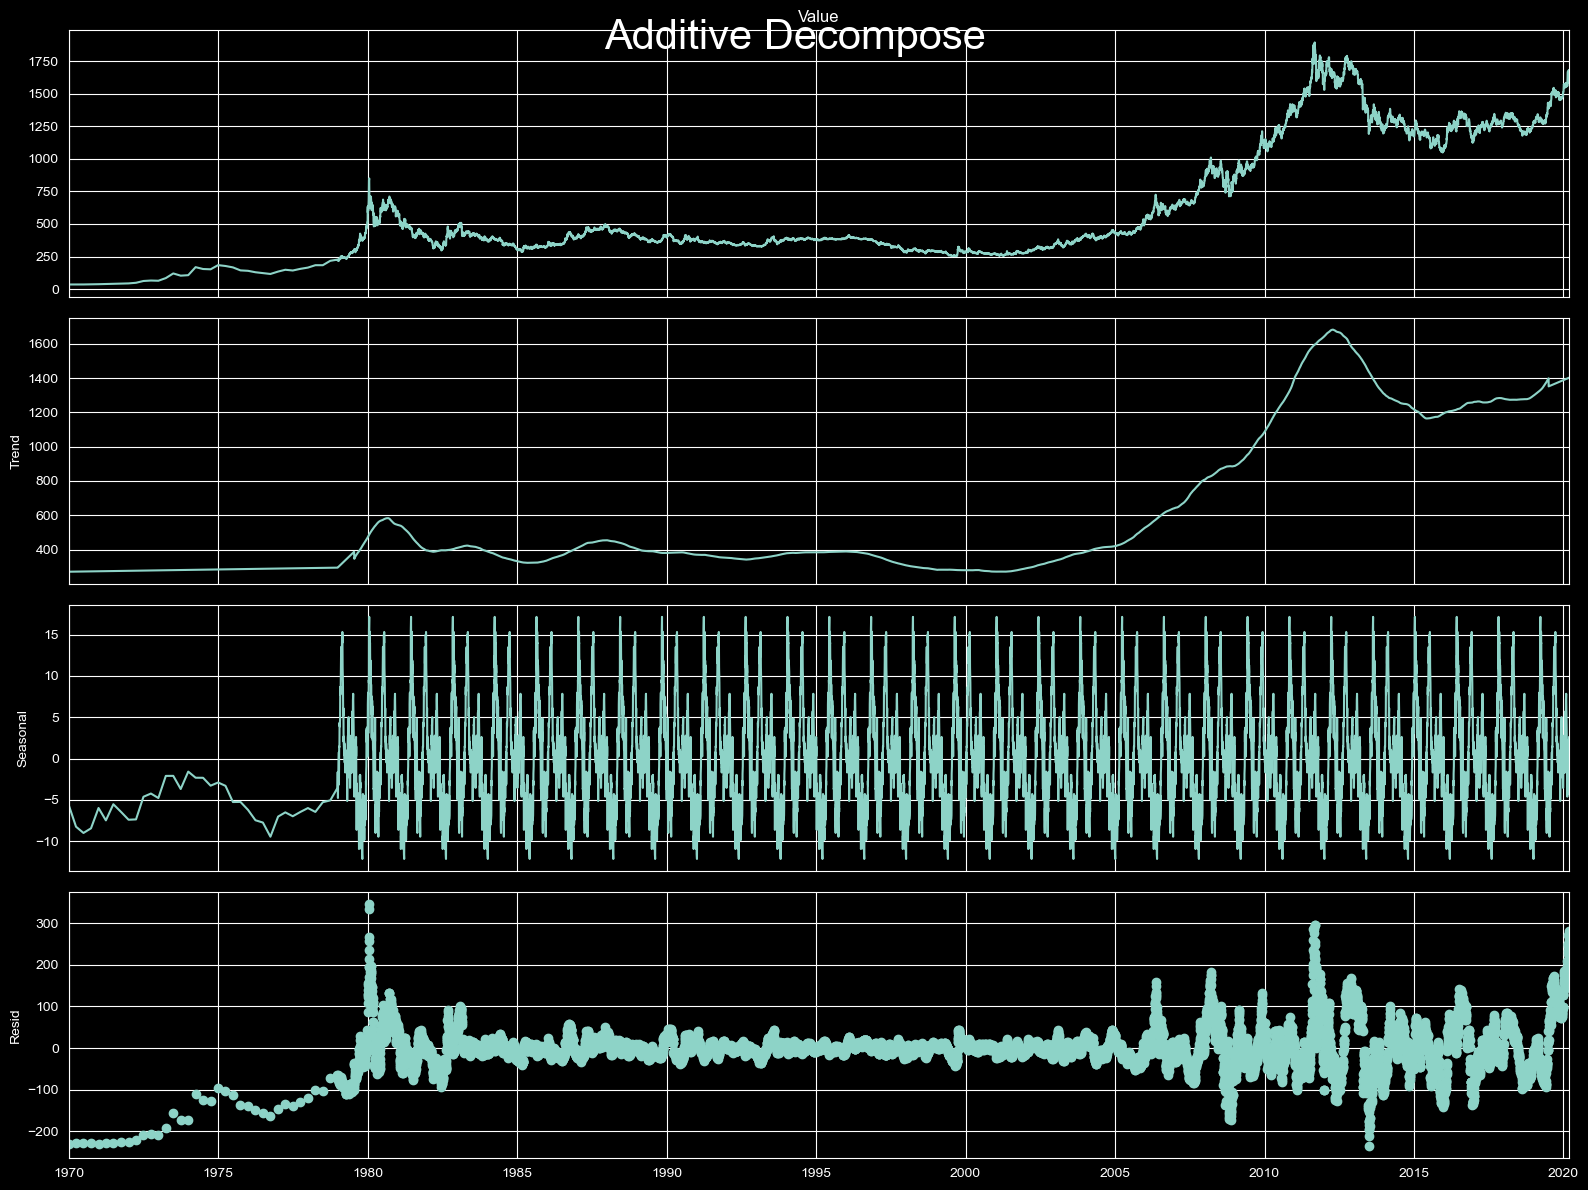

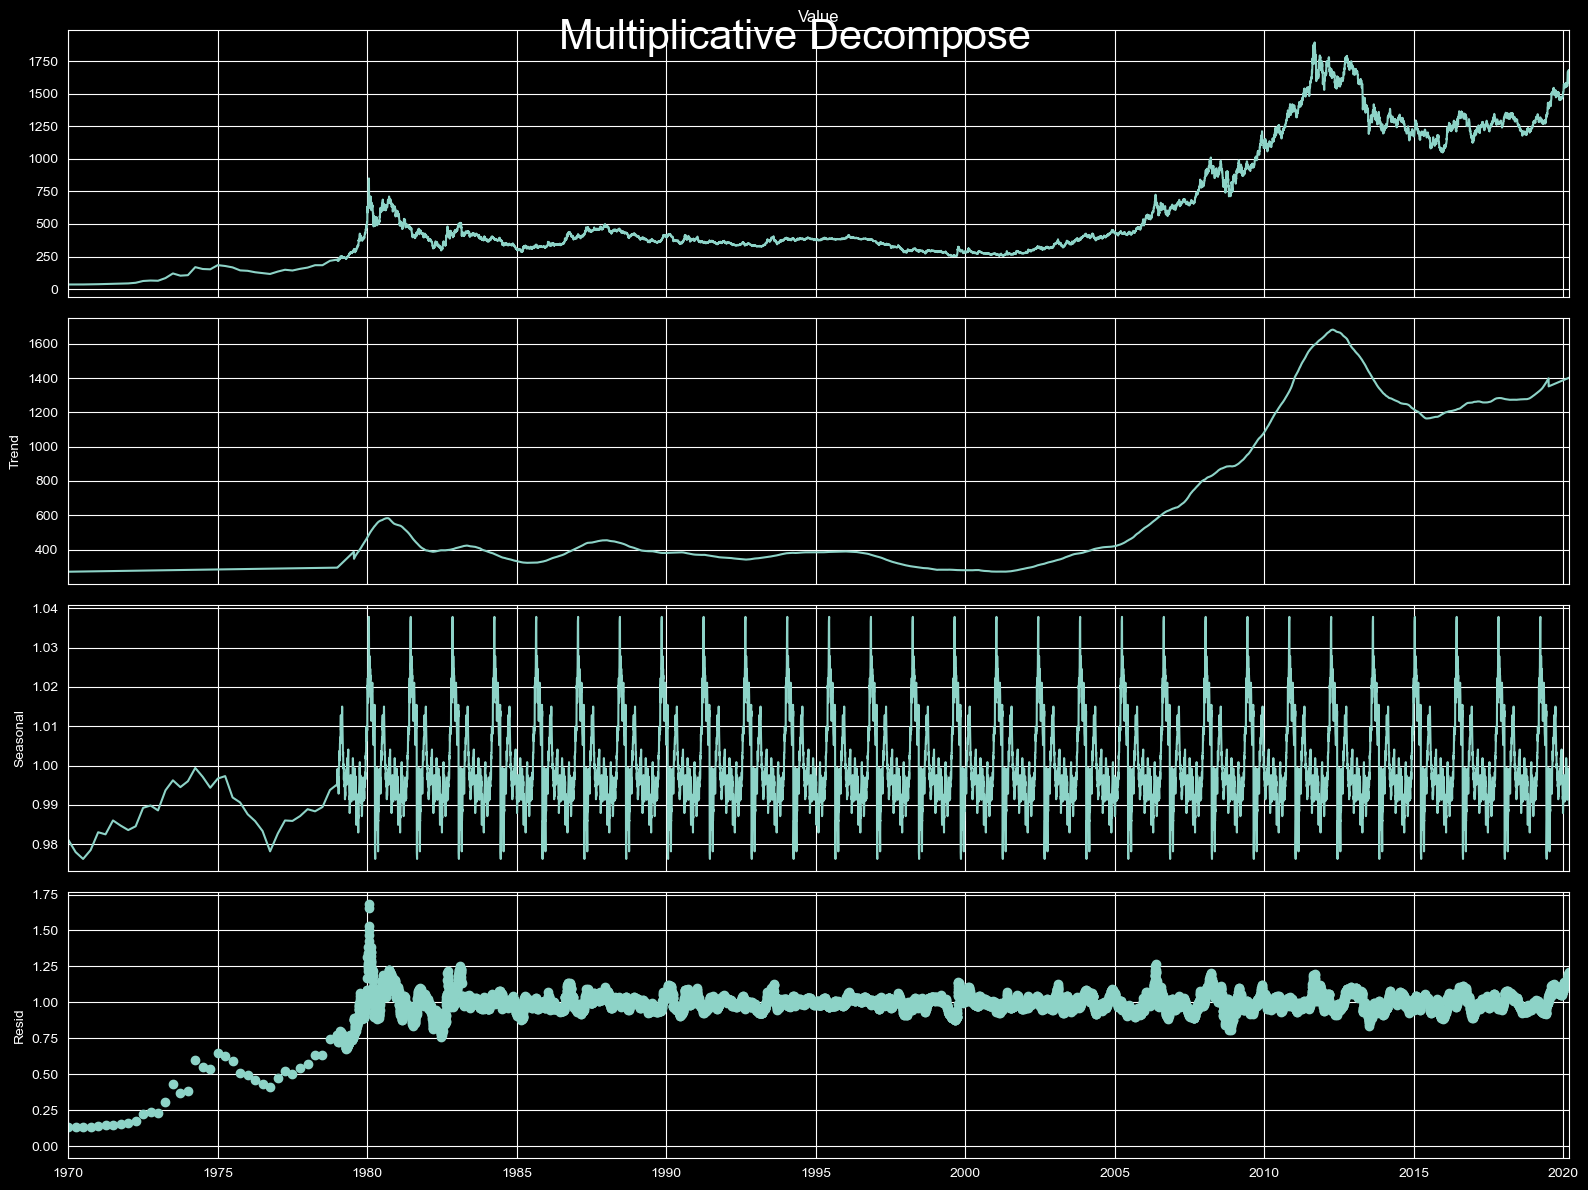

In [17]:
res_add, res_mul = decompose(df, 'Open')

# Check for the stationarity
  * **Mean & Variance should be constant, inorder to achieve stationarity**

**Rolling Statistics**

In [18]:
# Calculating rolling mean for 12 months
rolling_mean = df.rolling(window = 12).mean()

# Calculating rolling standard deviation for 12 months
rolling_std = df.rolling(window = 12).std()

Visualize the rolling Statistics

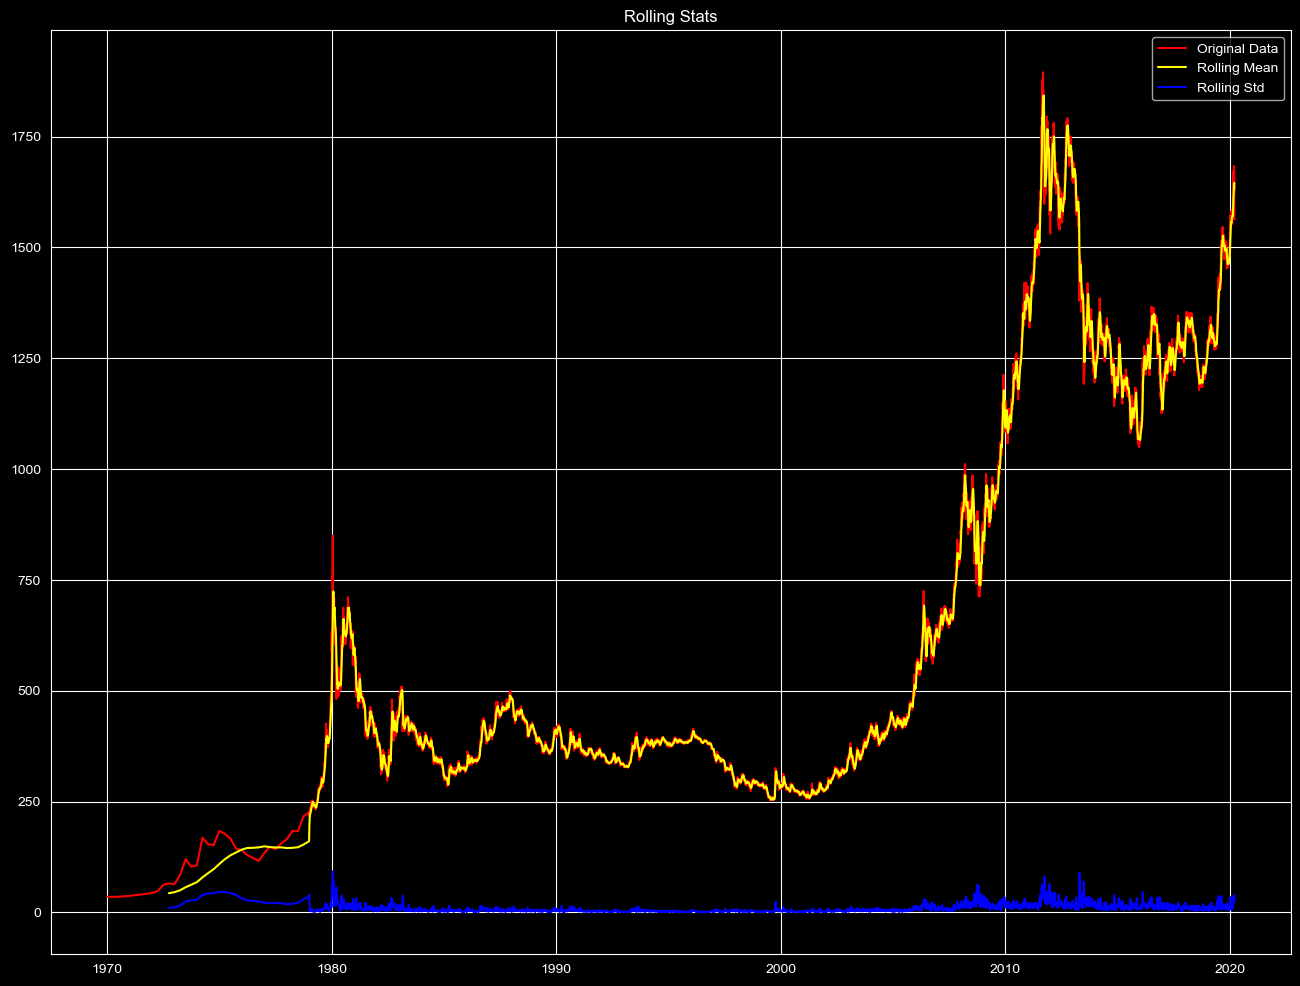

In [19]:
original_data = plt.plot(df, color = "red", label = "Original Data")
roll_mean = plt.plot(rolling_mean, color = "yellow", label = "Rolling Mean")
roll_std = plt.plot(rolling_std, color = "blue", label = "Rolling Std")
plt.legend()
plt.title("Rolling Stats")
plt.show()

Checkinng for Stationarity now with ADFuller Test

In [20]:
from statsmodels.tsa.stattools import adfuller
# from numpy import log

result = adfuller(df.Value.dropna())

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -0.07112124453813368
p-value: 0.9522400769147396


In [21]:
if result[1] > 0.05:
    print("Not stationary")
else:
    print("Stationary")

Not stationary


Insights :
- Since p-value is greater than the significance level(0.05), let’s difference the series and see how the autocorrelation plot looks like.

# Achieving the stationarity


- Differencing / Shift
- Log Transformation

Helper Function
- Creating a Helper Function for easy implementation 

In [22]:
def helperFunction(df):
    
# Calculating rolling mean for 12 months
    rolling_mean = df.rolling(window = 12).mean()

  # Calculating rolling standard deviation for 12 months
    rolling_std = df.rolling(window = 12).std()

  # Visualization
    original_data = plt.plot(df, color = "red", label = "Original Data")
    roll_mean = plt.plot(rolling_mean, color = "yellow", label = "Rolling Mean")
    roll_std = plt.plot(rolling_std, color = "blue", label = "Rolling Std")
    plt.legend()
    plt.title("Rolling Stats")
    plt.show()

    results = adfuller(df)
    if results[1] > 0.05:
        print("Not Stationary")
    else:
        print("Stationary")

Applying log transformation for stationarity

In [23]:
# Log transformed data
df_log = np.log(df)

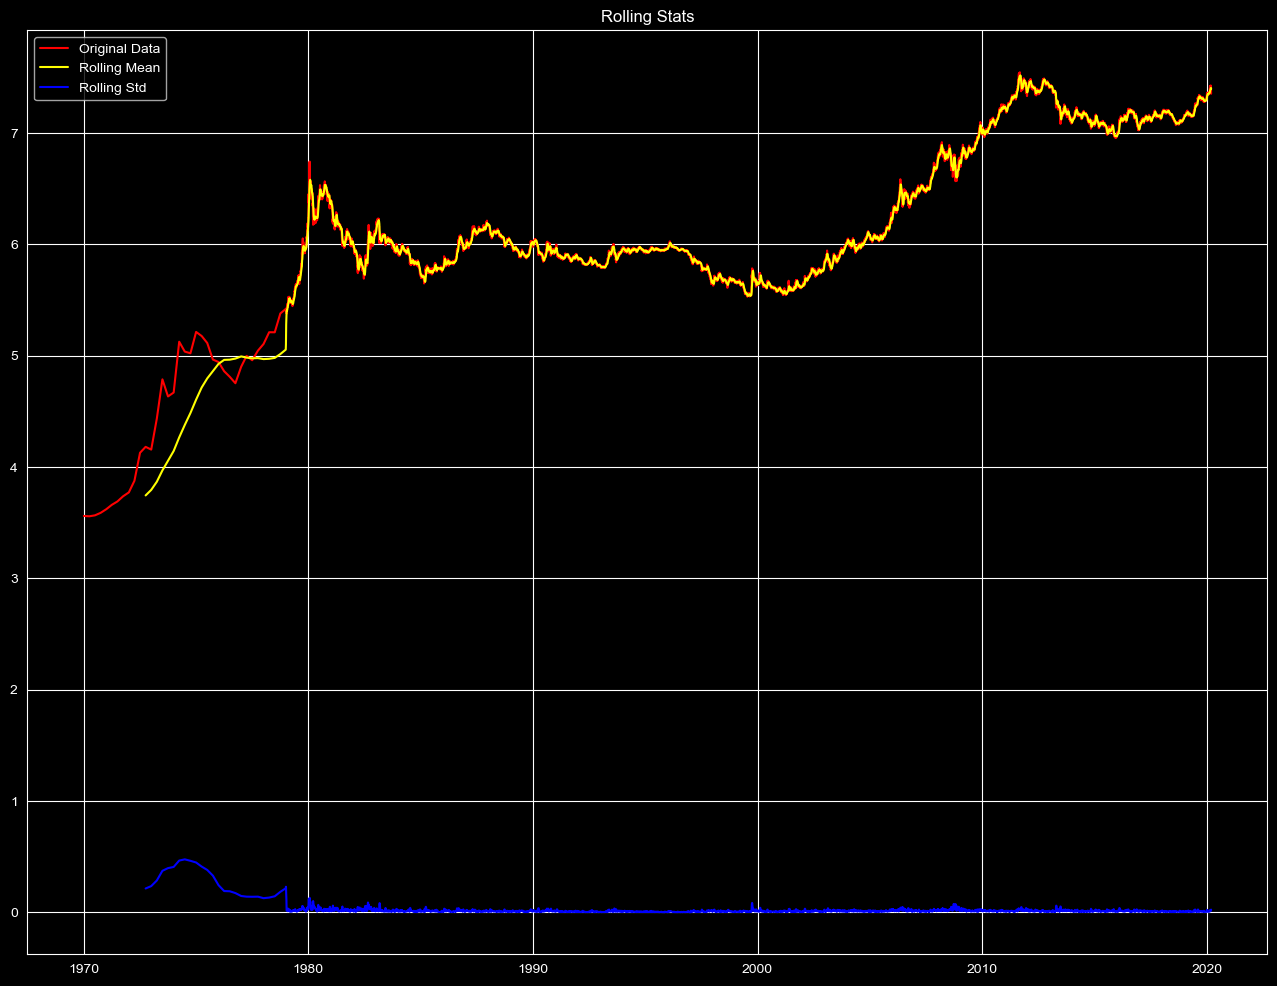

Not Stationary


In [24]:
helperFunction(df_log)

Insights : 
- From the above graph, it appears to be not stationary. Let's try differencing now.

Applying Differencing for reaching Stationarity

In [25]:
dflogDiff1 = df_log.diff().dropna()

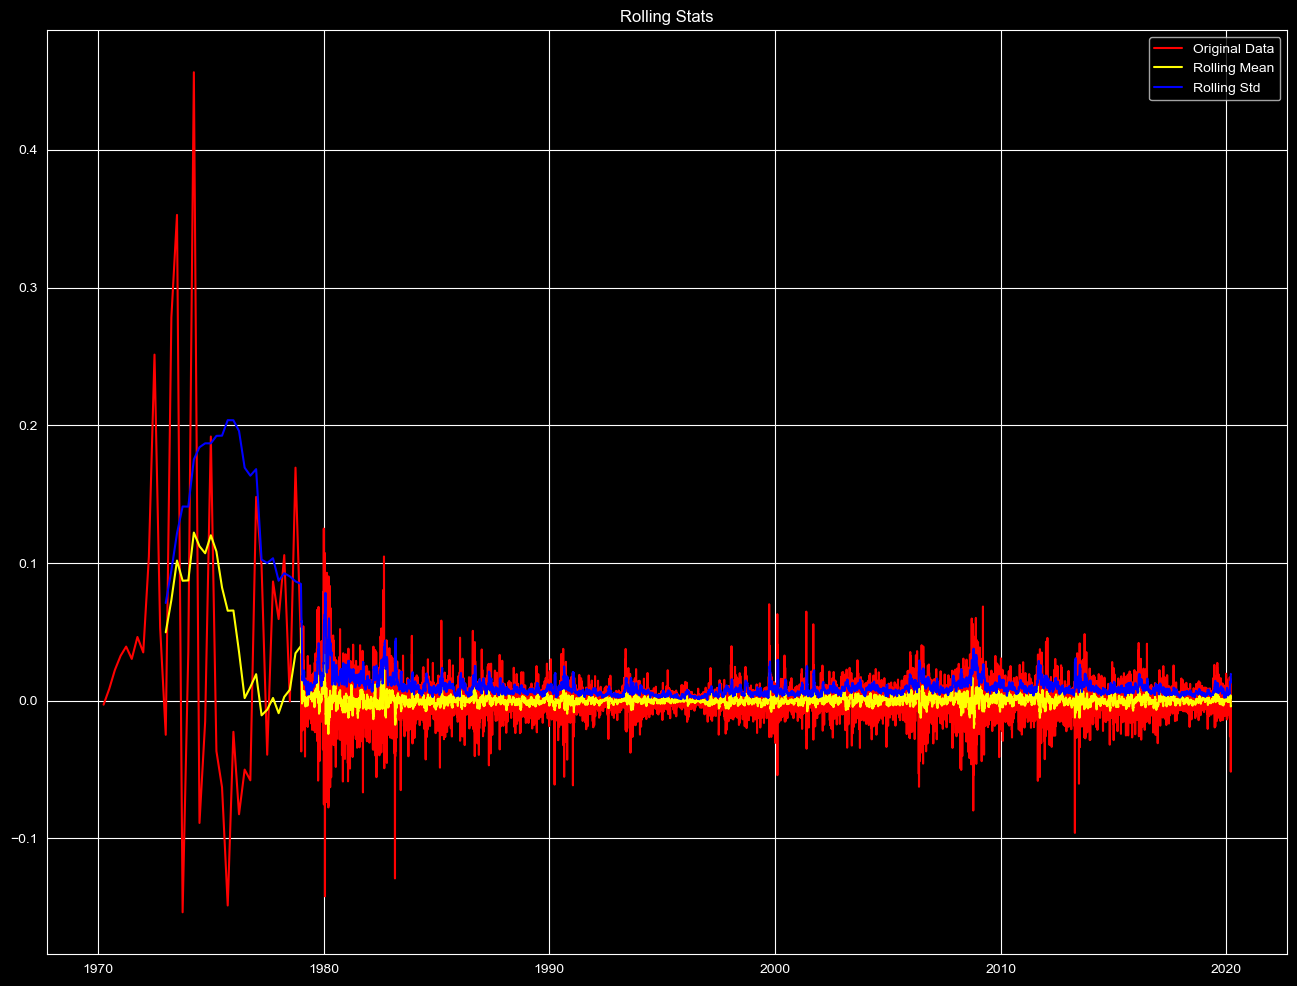

Stationary


In [26]:
helperFunction(dflogDiff1)

Insights :
- From the above data, we can see that the time series has attained stationarity with just ONE orders of differencing. So need for going with the SECOND orders

# Decomposition

 Let us now break down the 3 components of the log scale series using a system libary function. Once, we separate our the components, we can simply ignore trend & seasonality and check on the nature of the residual part.

In [27]:
decomposition = seasonal_decompose(dflogDiff1, period=12)

Seperation of Trend, Seasonality and Residuals

In [28]:
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

Visualize

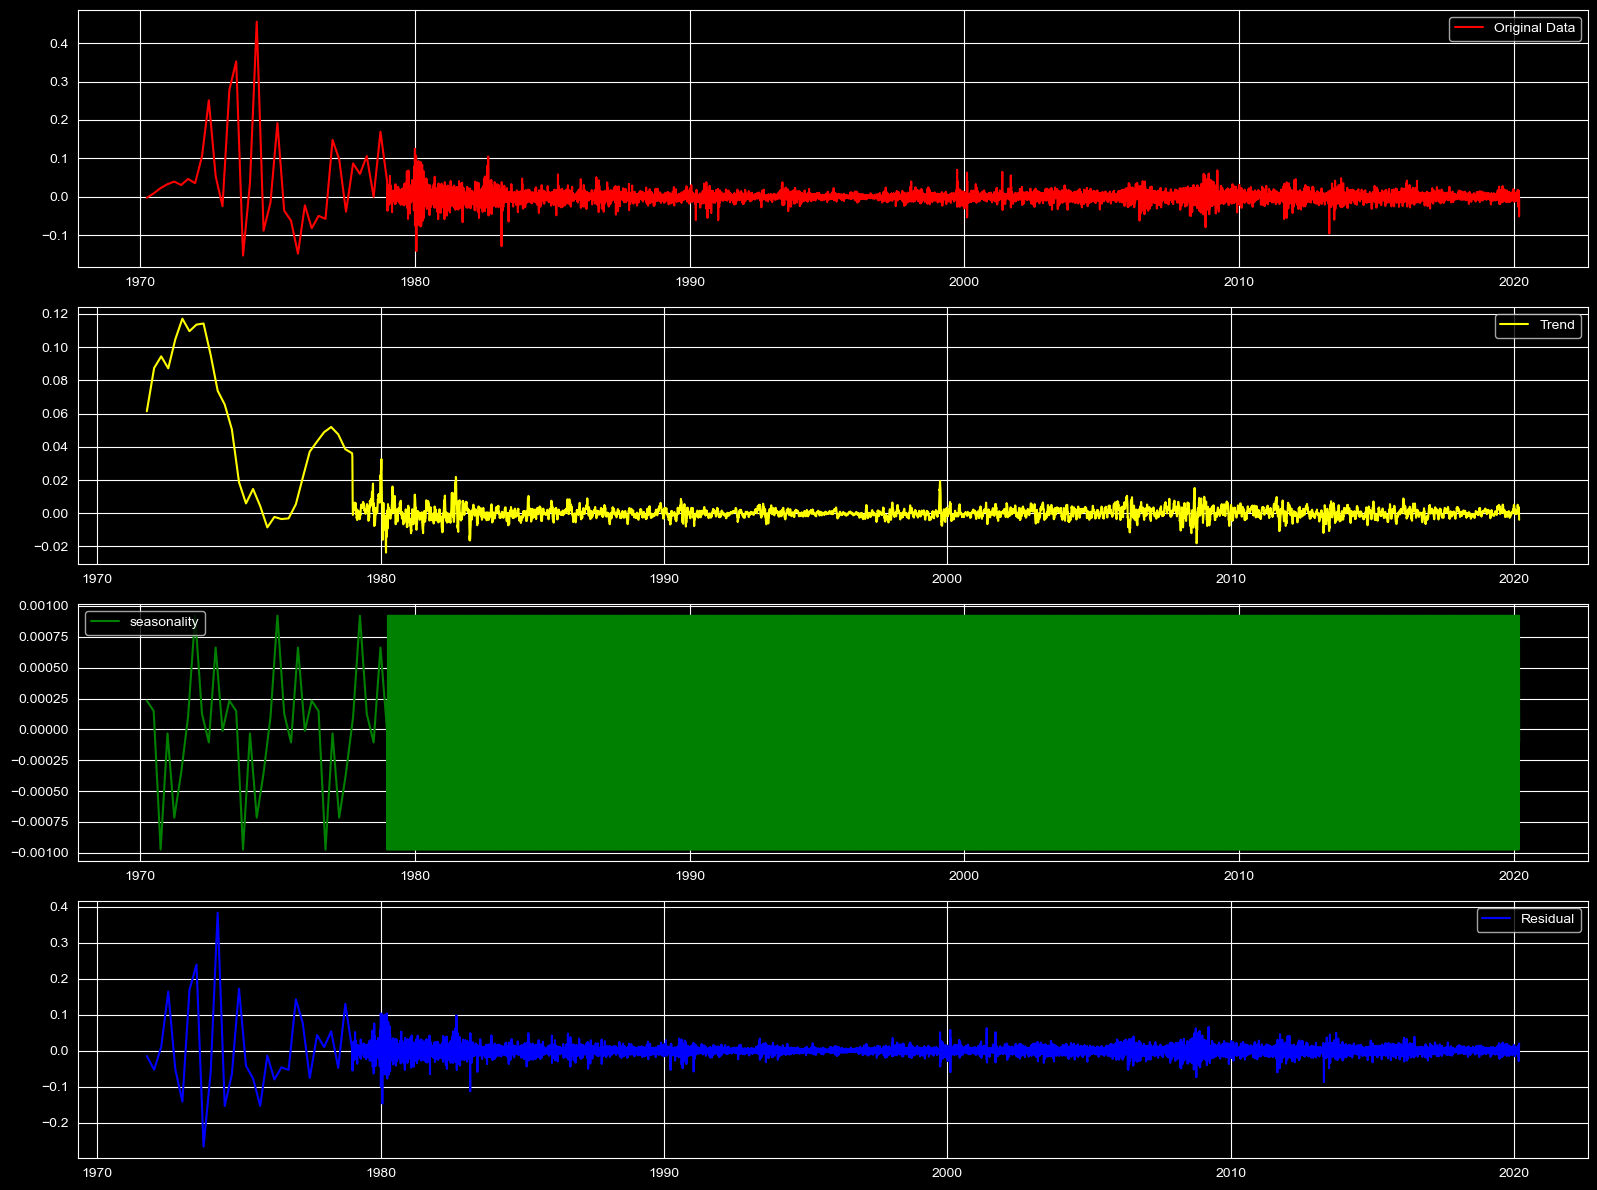

In [29]:
plt.subplot(411)
plt.plot(dflogDiff1, label = 'Original Data', color = 'red')
plt.legend()

plt.subplot(412)
plt.plot(trend, label = 'Trend', color = 'yellow')
plt.legend()

plt.subplot(413)
plt.plot(seasonality, label = 'seasonality', color = 'green')
plt.legend()

plt.subplot(414)
plt.plot(residual, label = 'Residual', color = 'blue')
plt.legend()
plt.tight_layout()

# Discovering the orders for Model

ACF

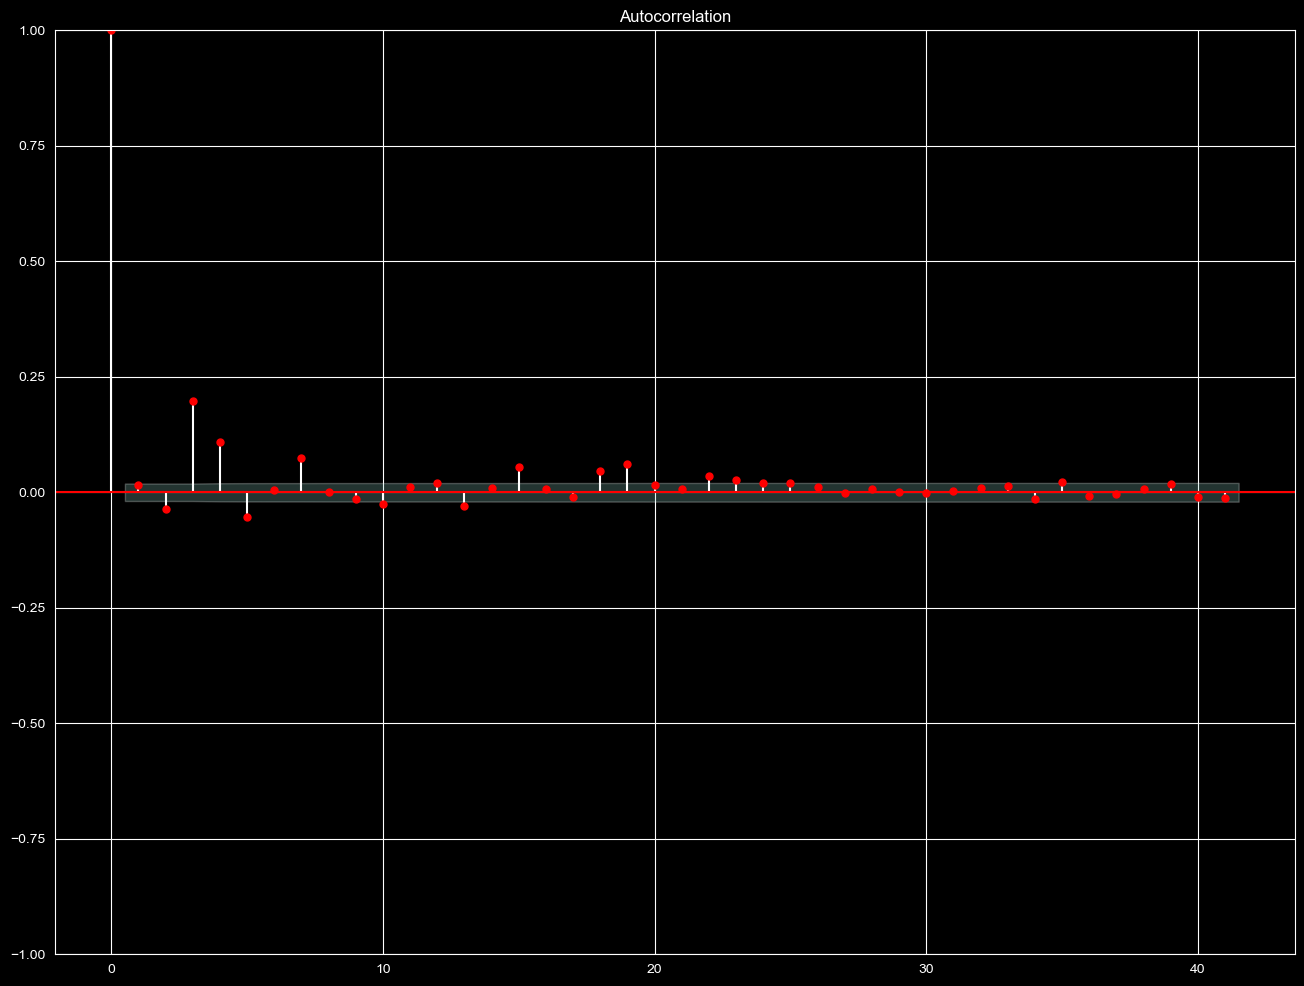

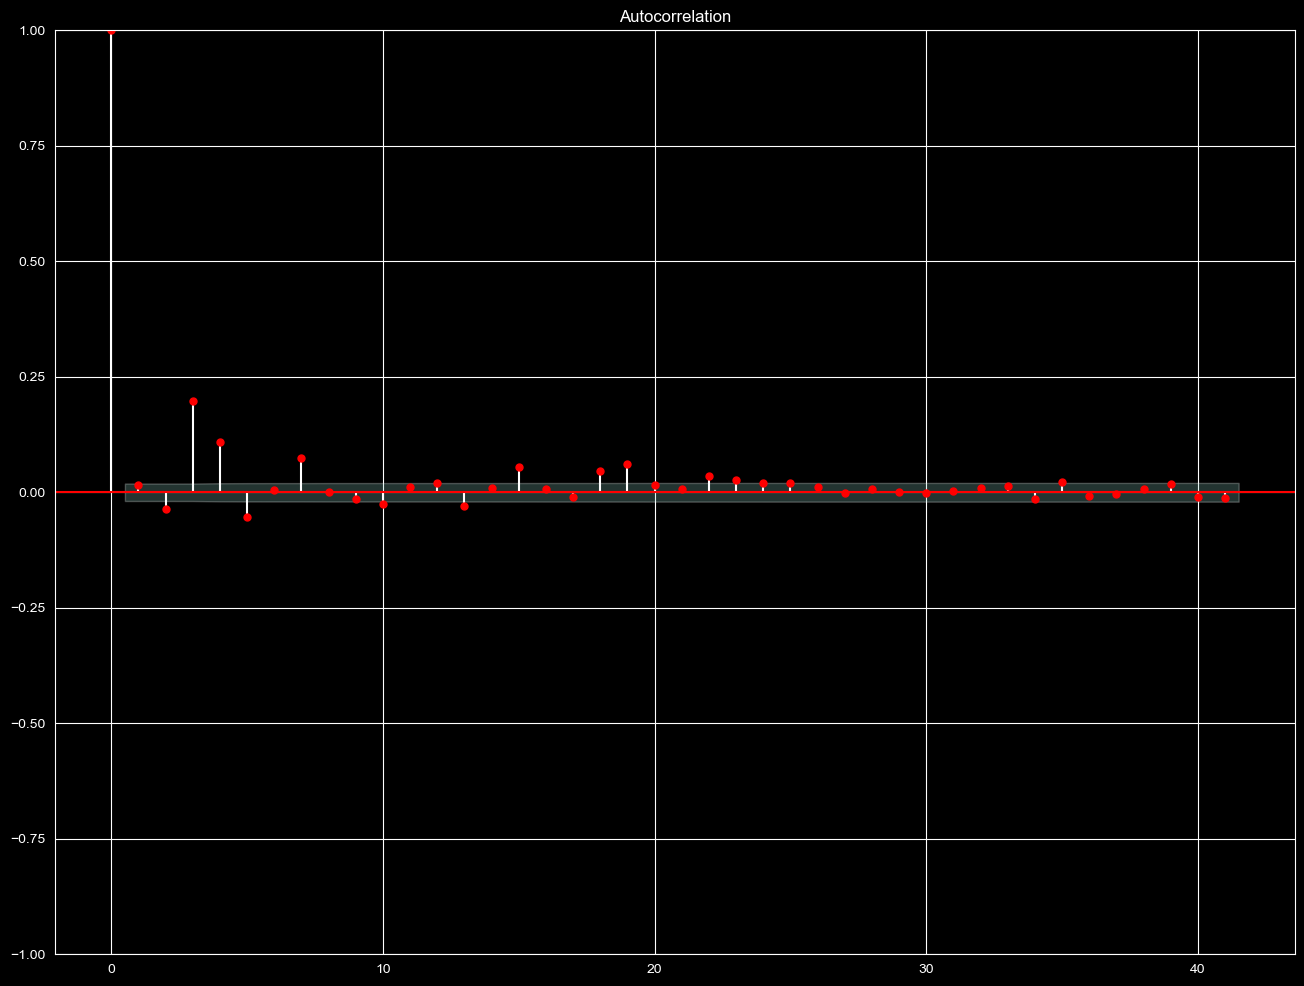

In [30]:
plot_acf(dflogDiff1, color = "red")

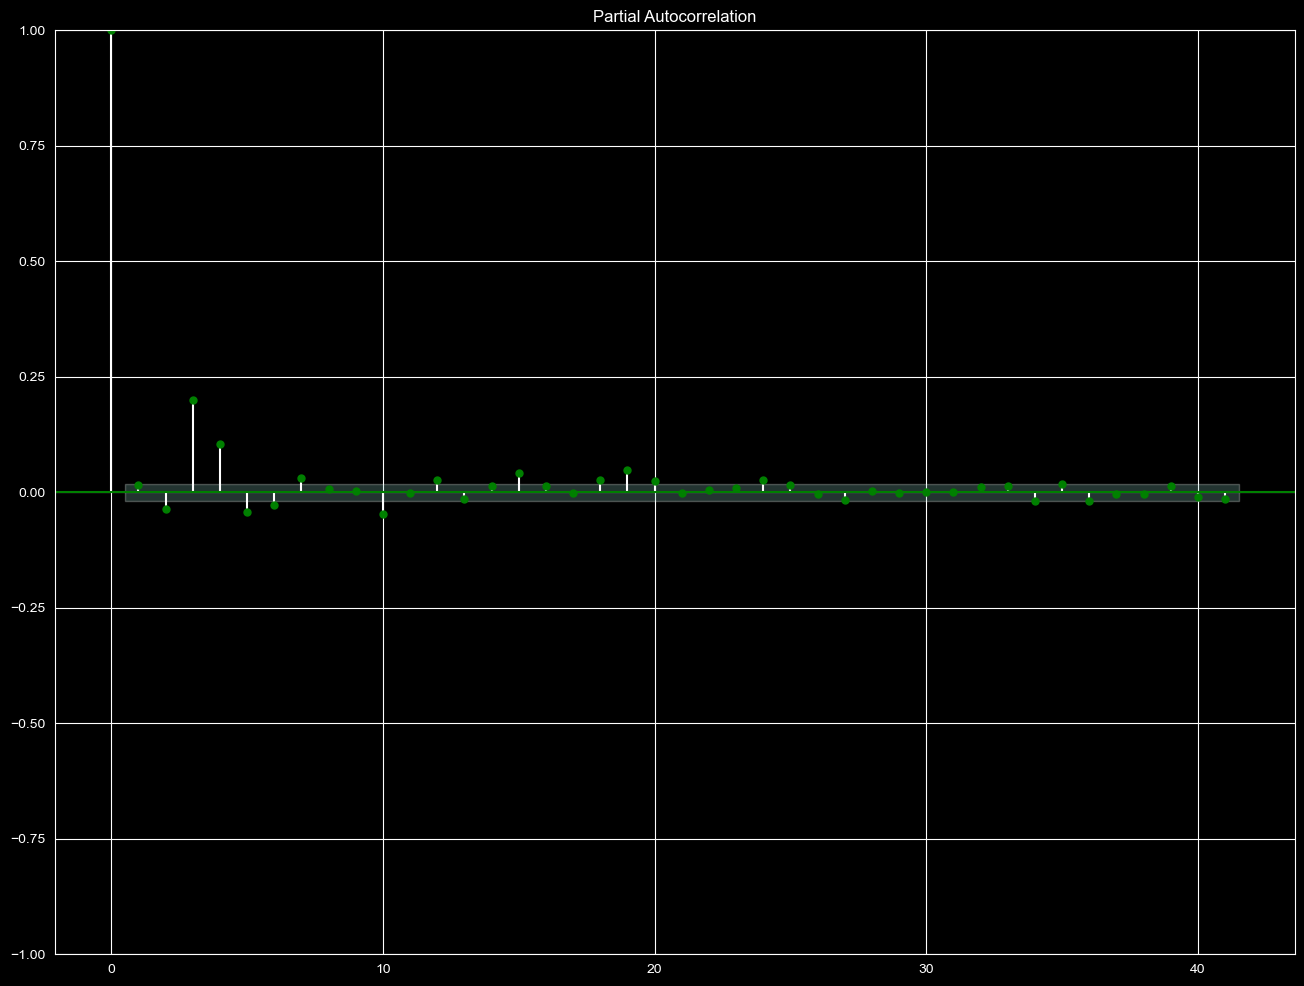

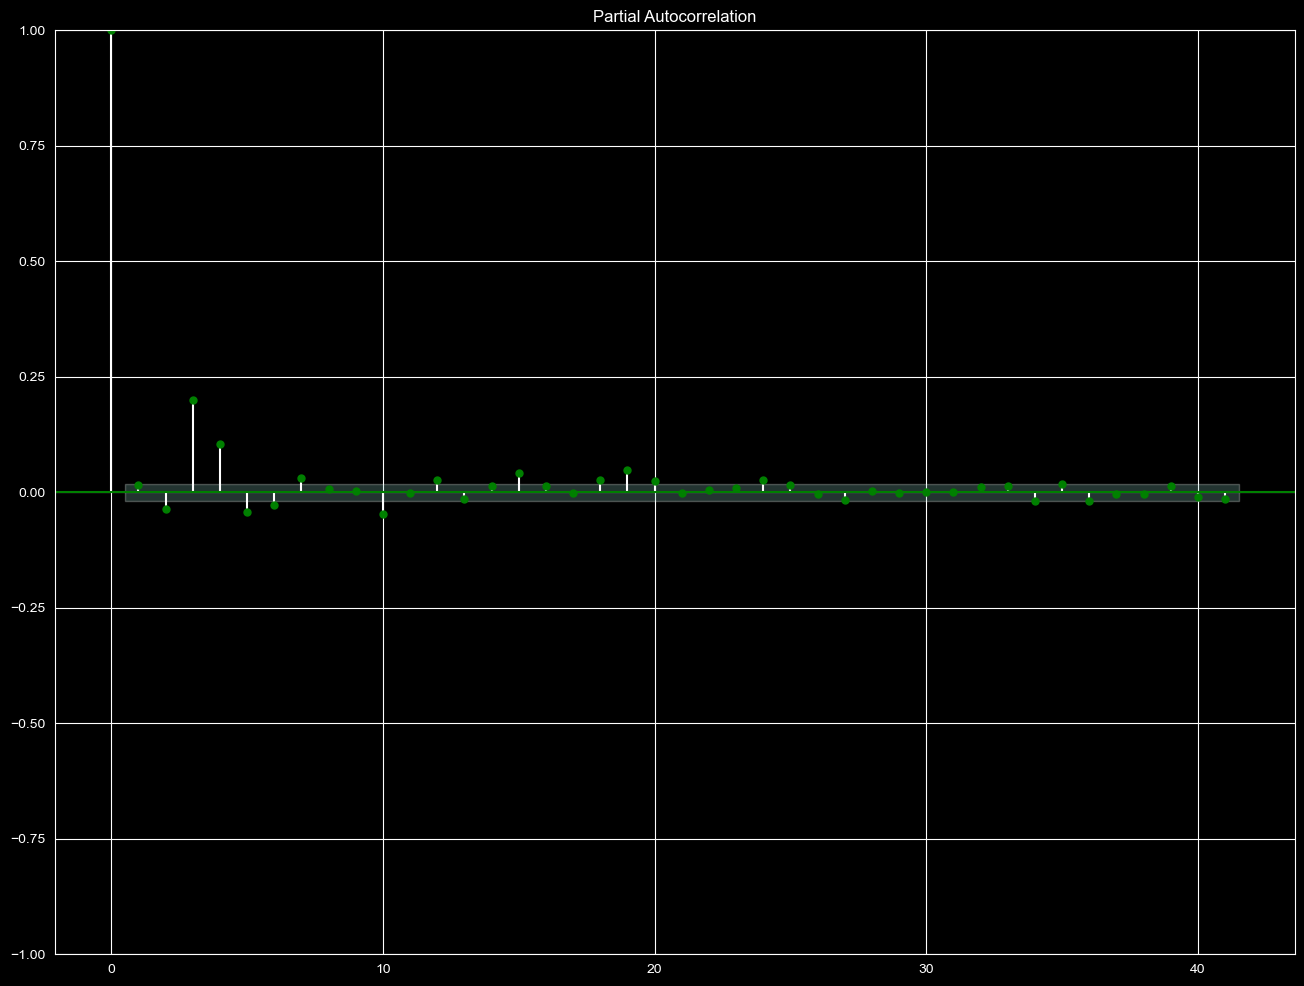

In [31]:
plot_pacf(dflogDiff1, color = "green")

# Model Building

In [32]:
import itertools
from statsmodels.tsa.arima.model import ARIMA

# Define ranges for p and q
p = range(0, 3) 
q = range(0, 3) 
d = [1]  

# Generate all combinations of p, d, q
pdq = list(itertools.product(p, d, q))

# Initialize variables to store the best model's information
best_aic = float('inf')
best_order = None

# Iterate over each combination of p, d, q
for order in pdq:
    try:
        model = ARIMA(dflogDiff1.dropna(), order=order)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
    except:
        continue

# Output the best model's order and AIC
print(f"Best model order: {best_order} with AIC: {best_aic}")

Best model order: (2, 1, 2) with AIC: -61261.87924882032


Train-Test Split

In [33]:
from datetime import datetime,timedelta

train_dataset_begin=datetime(1995,1,1)
train_dataset_end=datetime(2015,1,1)
test_dataset_end=datetime(2020,3,13)

In [34]:
X_train=df[train_dataset_begin:train_dataset_end]
X_test=df[train_dataset_end+timedelta(days=1):test_dataset_end]

##prediction
pred_start_date=X_test.index[0]
pred_end_date=X_test.index[-1]

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                 5219
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -19429.247
Date:                Wed, 31 Jul 2024   AIC                          38868.494
Time:                        00:53:26   BIC                          38901.294
Sample:                    01-02-1995   HQIC                         38879.965
                         - 01-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6084      0.007     87.092      0.000       0.595       0.622
ar.L2         -0.9793      0.007   -141.768      0.000      -0.993      -0.966
ma.L1         -0.6185      0.007    -85.509      0.0

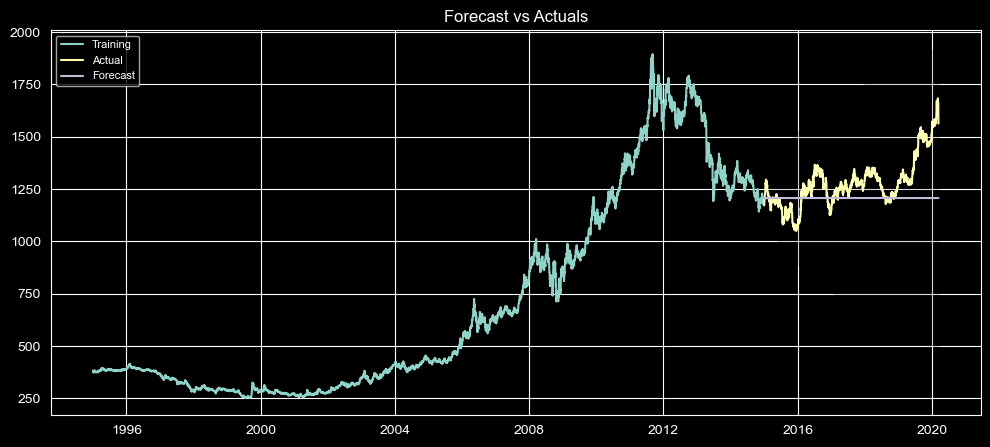

In [35]:

# Build Model
model = ARIMA(X_train, order=(2, 1, 2))
fitted = model.fit()
print(fitted.summary())

# Forecast
forecast = fitted.get_forecast(steps=len(X_test))
fc = forecast.predicted_mean
conf = forecast.conf_int(alpha=0.05)

# Convert to pandas Series
fc_series = pd.Series(fc, index=X_test.index)
lower_series = pd.Series(conf.iloc[:, 0], index=X_test.index)
upper_series = pd.Series(conf.iloc[:, 1], index=X_test.index)

# Plot
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(X_train, label='Training')
plt.plot(X_test, label='Actual')
plt.plot(fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Accuracy Metrics for Time Series Forecasting

# Typically, we will use three accuracy metrices:-

- MAPE
- Correlation and
- Min-Max Error
- The above three are percentage errors that vary between 0 and 1. That way, we can judge how good is the forecast irrespective of the scale of the series

In [36]:
# Calculate accuracy metrics
def forecast_accuracy(forecast, actual):
    forecast = np.asarray(forecast).flatten()
    actual = np.asarray(actual).flatten()
    if forecast.shape[0] != actual.shape[0]:
        raise ValueError("Forecast and actual arrays must have the same length.")
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))  # MAPE
    corr = np.corrcoef(forecast, actual)[0, 1]  # Correlation coefficient
    mins = np.minimum(forecast, actual)
    maxs = np.maximum(forecast, actual)
    minmax = 1 - np.mean(mins / maxs)  # Min-Max
    return {'mape': mape, 'corr': corr, 'minmax': minmax}

# Calculate and print accuracy metrics
accuracy_metrics = forecast_accuracy(fc, X_test.values)
print(accuracy_metrics)

{'mape': 0.07320868071541596, 'corr': -0.0022555301589169243, 'minmax': 0.0722243277192538}


Insights:
- MAPE of 7.32% is relatively low, suggesting that the model's predictions are fairly accurate in terms of percentage error.
  A lower MAPE indicates better forecast accuracy.
- Min-Max Accuracy: 7.22 indicates good performance in tracking the actual values' range. A lower value indicates that the forecasted values are relatively close to the actual values across their range

# Auto ARIMA Forecasting in Python


auto_arima() uses a stepwise approach to search multiple combinations of p, d, q parameters and chooses the best model that has the least AIC.

In [37]:
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm

model = pm.auto_arima(df.Value, 
                      start_p=1, 
                      start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=78088.281, Time=9.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=78090.196, Time=0.56 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=78090.620, Time=1.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=78090.554, Time=1.66 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=78090.847, Time=0.43 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=78081.126, Time=13.47 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=78087.969, Time=1.63 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=78082.775, Time=15.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=78048.396, Time=27.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=78081.191, Time=14.93 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=78049.950, Time=33.68 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=78084.745, Time=18.37 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=78082.704, Time=15.82 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=78086.029, Time=40.90 sec
 ARIMA(2,1,

Insights :
    
- According to the AutoARIMA, the best model has the values 2 for p, 1 for d and 2 for q.

Let’s review the residual plots using stepwise_fit.

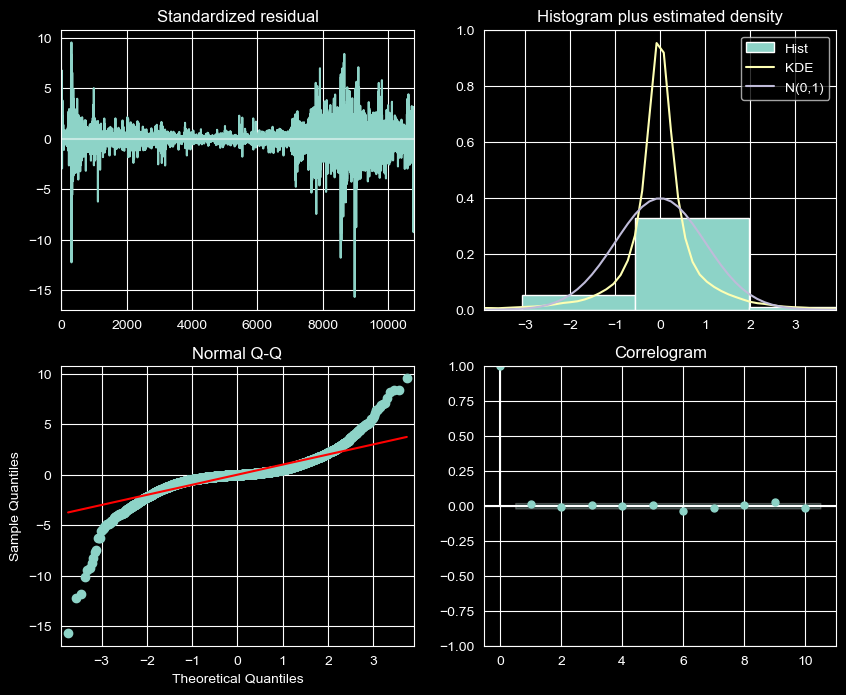

In [38]:
model.plot_diagnostics(figsize=(10,8))
plt.show()

Interpretation of plots in plot diagnostics:

- Standardized residual: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

- Histogram: The density plot suggest normal distribution with mean slighlty shifted towards right.

- Theoretical Quantiles: Mostly the dots fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

- Correlogram: The Correlogram, (or ACF plot) shows the residual errors are not autocorrelated. The ACF plot would imply that there is some pattern in the residual errors which are not explained in the model. So we will need to look for more X’s (predictors) to the model.

# Forecasting

Overall, the model seems to be a good fit. So, let's use it to forecast.



In [39]:
df.Value

Date
1970-01-01      35.20
1970-04-01      35.10
1970-07-01      35.40
1970-10-01      36.20
1971-01-01      37.40
               ...   
2020-03-09    1672.50
2020-03-10    1655.70
2020-03-11    1653.75
2020-03-12    1570.70
2020-03-13    1562.80
Name: Value, Length: 10787, dtype: float64

In [40]:
df.reset_index(inplace=True)

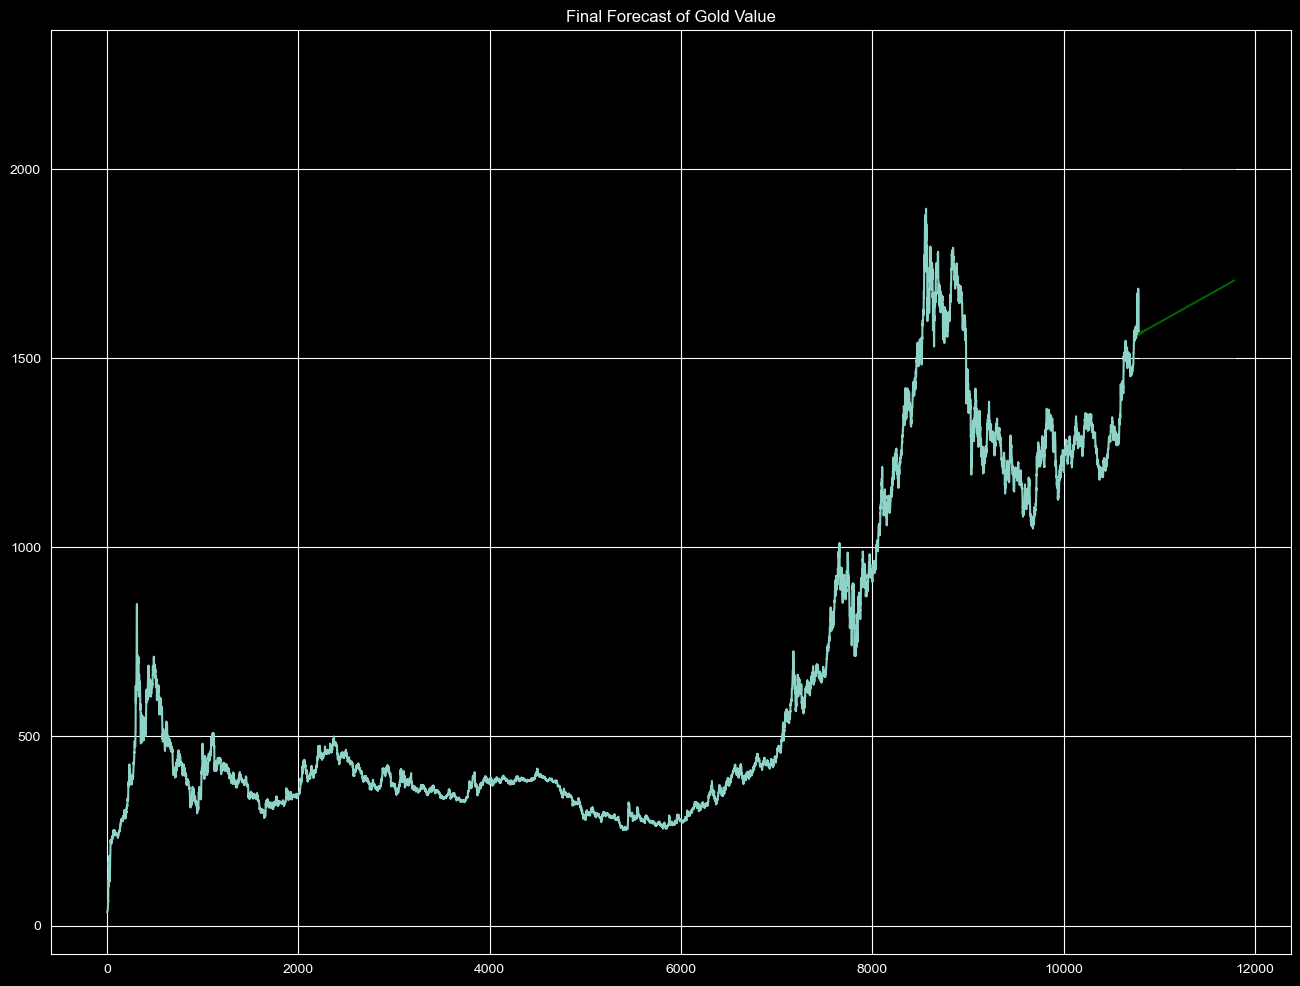

In [41]:
# Forecast
n_periods = 1000
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.Value), len(df.Value) + n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.Value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color='k', alpha=.15)

plt.title("Final Forecast of Gold Value")
plt.show()